# Noiseness analysis

These cells assume that each JSON file is named in the form "seed_iteration" (for example, "23_1.json", "23_2.json", …, "23_10.json") and that each file contains fitness data for a simulation run on a fixed track (the seed). 
This approach lets you compute the noisiness and the variability across simulation runs for the same track -> to quantify how stable or noisy each track’s outcomes are.

In [1]:
import os
import json
import pandas as pd

DATA_DIR = './voronoi'
records = []

for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.json'):
        continue
    try:
        base, _ = os.path.splitext(filename)
        parts = base.split('_')
        if len(parts) < 2:
            continue
        seed = parts[0]
        iteration = parts[1]
        filepath = os.path.join(DATA_DIR, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            data = json.load(file)
        fitness = data.get('fitness')
        if fitness is None:
            continue
        fitness['seed'] = int(seed)
        fitness['iteration'] = int(iteration)
        records.append(fitness)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

df = pd.DataFrame(records)
print("Loaded Data:")
print(df.head())

Loaded Data:
       length    deltaX    deltaY  deltaAngleDegrees  speed_entropy  \
0  607.667297  3.703819  0.161852           3.947157       3.034797   
1  608.804260  1.579643 -0.162773          -0.285676       2.217535   
2  607.286011  2.446960 -1.589397           4.246619       3.120563   
3  607.800781  2.244873  0.103592           2.038856       3.093135   
4  608.814575  2.649223  0.451601           3.343395       3.009559   

   acceleration_entropy  braking_entropy  positions_mean  avg_radius_mean  \
0              2.459600         1.119224             0.0       103.132765   
1              1.127616         0.633255             0.0       101.521963   
2              2.648452         1.184493             0.0       103.121860   
3              2.619468         1.039656             0.0       102.957365   
4              2.580717         1.125068             0.0       102.987118   

   gaps_mean  right_bends  avg_radius_var  total_overtakes  straight_sections  \
0   5.050005    

Compute descriptive statistics grouped by seed. This lets you quantify the noisiness (variance and standard deviation) of the features for each fixed track.

In [2]:
features = [col for col in df.columns if col not in ['seed', 'iteration']]
group_stats = df.groupby('seed')[features].agg(['mean', 'std']).reset_index()
group_stats.columns = ['_'.join(col).strip('_') for col in group_stats.columns.values]
print("Grouped Statistics:")
print(group_stats.head())

Grouped Statistics:
   seed  length_mean  length_std  deltaX_mean  deltaX_std  deltaY_mean  \
0     1   709.263354    0.610072     2.373552    1.446186     0.279944   
1     2   739.580365    0.507989     1.106280    0.859483    -0.212613   
2     3  1807.454944    0.612391     4.452453    4.198693    -2.180342   
3     4   893.233813    0.509677     1.282773    1.122345     0.184731   
4     5   819.891803    0.601395     1.733068    0.812983    -0.047915   

   deltaY_std  deltaAngleDegrees_mean  deltaAngleDegrees_std  \
0    0.873047               -2.824888               2.790167   
1    1.054980                1.375211               2.591910   
2    6.570584               -2.408514               1.205594   
3    1.055628               -0.414122               2.606419   
4    1.266700                0.310417               1.201681   

   speed_entropy_mean  ...  straight_sections_mean  straight_sections_std  \
0            2.925367  ...                    10.6               0.516398

Visualize noisiness for selected features with error bar plots.

All metrics: ['length', 'deltaX', 'deltaY', 'deltaAngleDegrees', 'speed_entropy', 'acceleration_entropy', 'braking_entropy', 'positions', 'avg_radius', 'gaps', 'right_bends', 'avg_radius_var', 'total_overtakes', 'straight_sections', 'gaps_var', 'left_bends', 'positions_var', 'curvature_entropy']


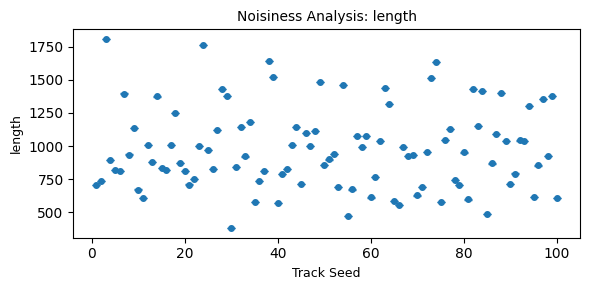

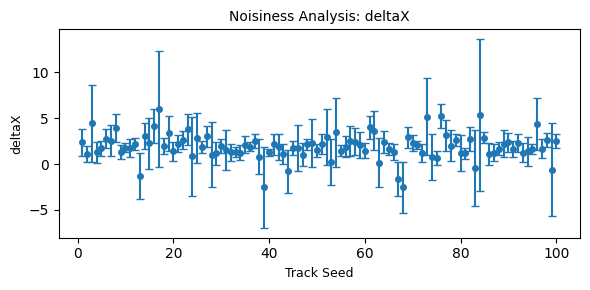

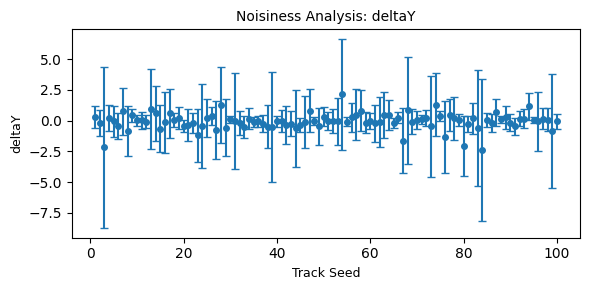

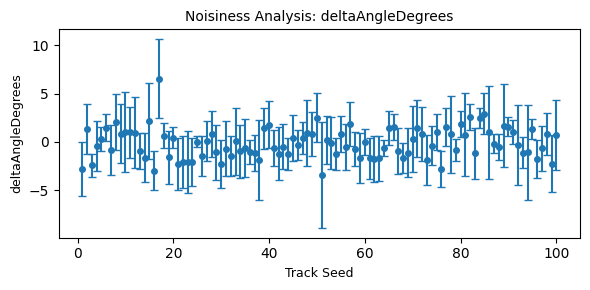

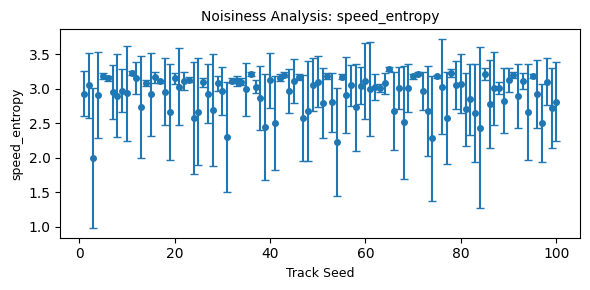

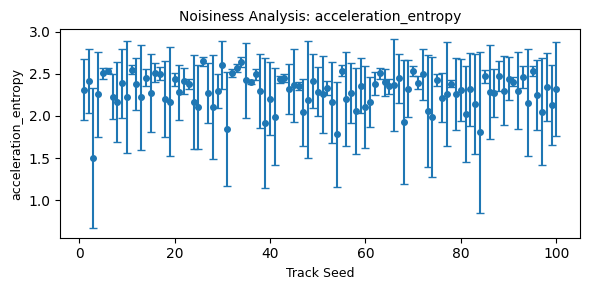

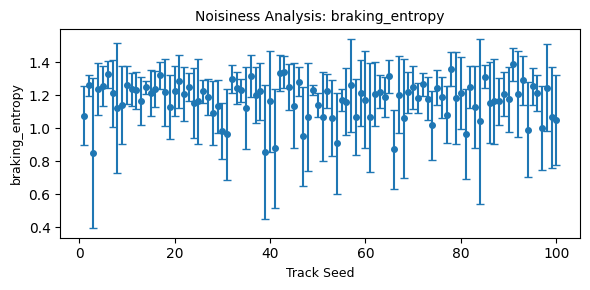

KeyError: 'positions_mean'

<Figure size 600x300 with 0 Axes>

In [13]:
# Extract all metric names based on columns ending with '_mean'
metric_names = [col.replace('_mean', '') for col in group_stats.columns if col.endswith('_mean')]
print("All metrics:", metric_names)

# Loop through all metrics to create smaller error bar plots
for metric in metric_names:
    plt.figure(figsize=(6, 3))  # Smaller figure size
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    
    plt.errorbar(group_stats["seed"], group_stats[mean_col],
                 yerr=group_stats[std_col],
                 fmt="o", capsize=3, markersize=4)
    plt.xlabel("Track Seed", fontsize=9)
    plt.ylabel(metric, fontsize=9)
    plt.title(f"Noisiness Analysis: {metric}", fontsize=10)
    plt.tight_layout()
    plt.show()


Compute and visualize the correlation matrix for all numeric features (including candidate fitness measures).

Correlation Matrix:
                        length    deltaX    deltaY  deltaAngleDegrees  \
length                1.000000 -0.008774 -0.007209          -0.108613   
deltaX               -0.008774  1.000000 -0.011948          -0.087512   
deltaY               -0.007209 -0.011948  1.000000          -0.034686   
deltaAngleDegrees    -0.108613 -0.087512 -0.034686           1.000000   
speed_entropy        -0.241134  0.087712  0.036027           0.029989   
acceleration_entropy -0.179790  0.056089  0.073420           0.005647   
braking_entropy      -0.099398  0.095784  0.025311           0.019823   
positions_mean        0.007283  0.056464 -0.000991          -0.024041   
avg_radius_mean       0.176168  0.100835 -0.074253           0.021841   
gaps_mean             0.111313  0.026410  0.012966          -0.021840   
right_bends           0.878946 -0.015186 -0.010161          -0.021506   
avg_radius_var        0.275241  0.072689 -0.083645           0.033580   
total_overtakes       0.143687 

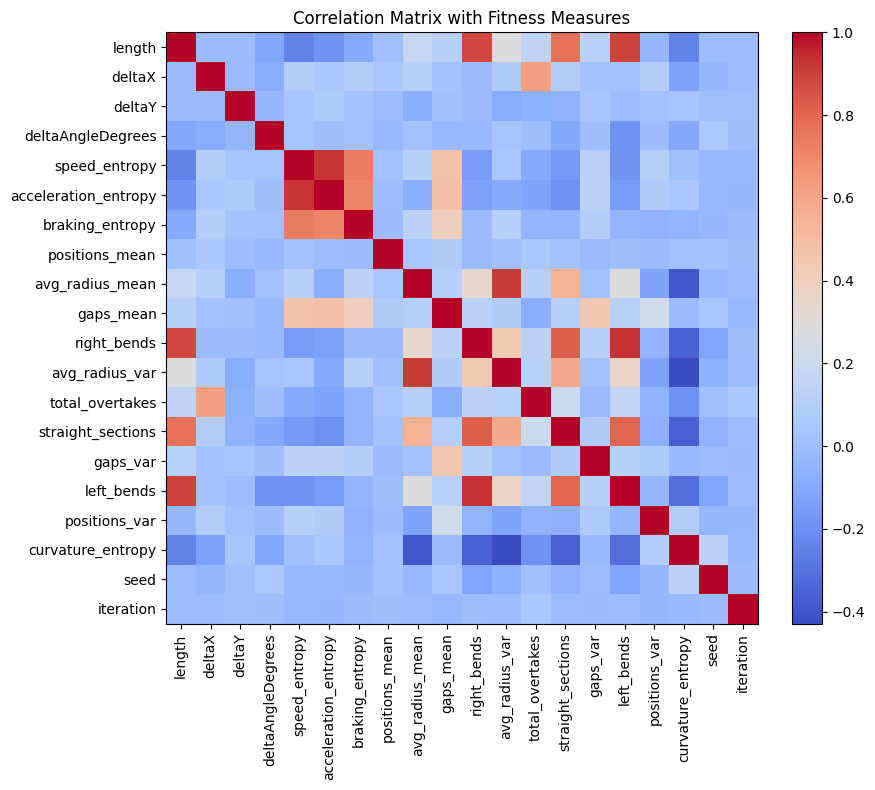


Significant Correlations (|r| >= 0.7):
length & right_bends: 0.88
length & straight_sections: 0.77
length & left_bends: 0.90
speed_entropy & acceleration_entropy: 0.92
speed_entropy & braking_entropy: 0.74
acceleration_entropy & braking_entropy: 0.71
avg_radius_mean & avg_radius_var: 0.91
right_bends & straight_sections: 0.82
right_bends & left_bends: 0.93
straight_sections & left_bends: 0.80


In [4]:
import numpy as np

corr = df.select_dtypes(include=[float, int]).corr()
print("Correlation Matrix:")
print(corr)

plt.figure(figsize=(10, 8))
cax = plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix with Fitness Measures")
plt.colorbar(cax, fraction=0.046, pad=0.04)
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90)
plt.yticks(ticks, corr.columns)
plt.tight_layout()
plt.show()

threshold = 0.7
print(f"\nSignificant Correlations (|r| >= {threshold:.1f}):")
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) >= threshold:
            print(f"{corr.columns[i]} & {corr.columns[j]}: {corr.iloc[i, j]:.2f}")

# Dimensionality Reduction & Visual Mapping

In this section, we load the JSON files that include the fixed-length spline vectors.
We convert these spline representations into a flattened feature vector for each track.
Then, we apply t-SNE and UMAP to project the high-dimensional track features into a 2D space.
Finally, we visualize the 2D embeddings to evaluate the visual diversity and see how the descriptors (represented by the 2D coordinates) relate to our other metrics.

In [5]:
from sklearn.manifold import TSNE
import umap

track_ids = []
spline_features = []
meta_data = []

for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.json'):
        continue
    filepath = os.path.join(DATA_DIR, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            genotype = json.load(file)
        if 'splineVector' not in genotype:
            continue
        spline = genotype['splineVector']
        feature_vector = []
        for point in spline:
            feature_vector.extend([point['x'], point['y']])
        spline_features.append(feature_vector)
        track_ids.append(genotype.get('id', filename))
        meta_data.append({
            'id': genotype.get('id', filename),
            'mode': genotype.get('mode'),
            'trackSize': genotype.get('trackSize'),
        })
    except Exception as e:
        print(f"Error reading {filename}: {e}")

import numpy as np

X = np.array(spline_features)
print(f"Loaded {X.shape[0]} tracks with feature dimension {X.shape[1]}.")

Loaded 993 tracks with feature dimension 200.


t-SNE Embedding
Map the spline feature vectors to a 2D space using t-SNE.

C:\Users\batman\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\batman\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\batman\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwarg

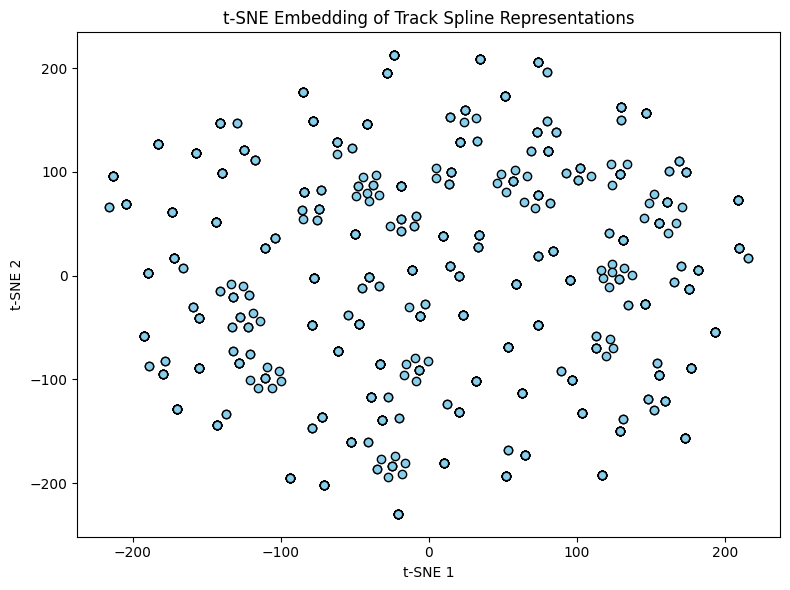

In [6]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='skyblue', edgecolor='k')
plt.title("t-SNE Embedding of Track Spline Representations")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

## UMAP Embedding

Apply UMAP as an alternative dimensionality reduction technique.

C:\Users\batman\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\batman\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


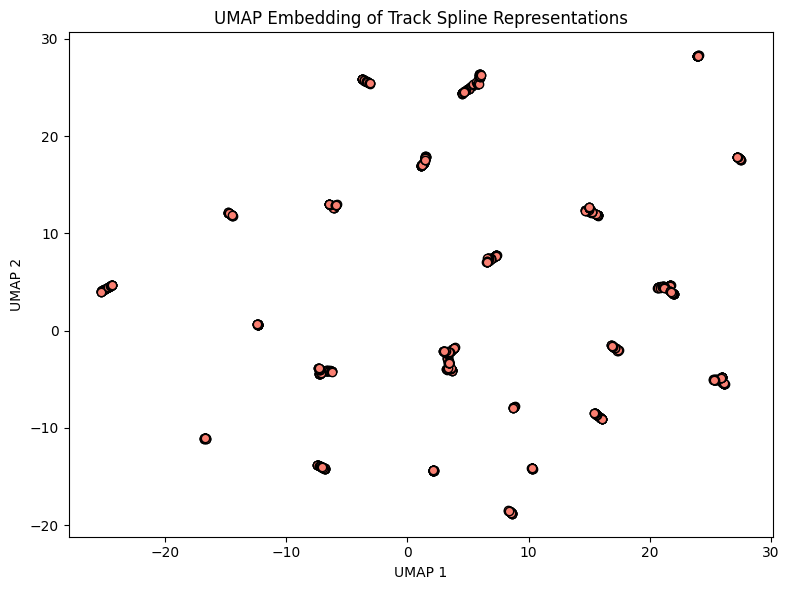

In [7]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='salmon', edgecolor='k')
plt.title("UMAP Embedding of Track Spline Representations")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


Comparing the Embeddings
Display both t-SNE and UMAP embeddings side by side for visual comparison.
Optionally, further analysis can correlate these 2D coordinates with other metrics.

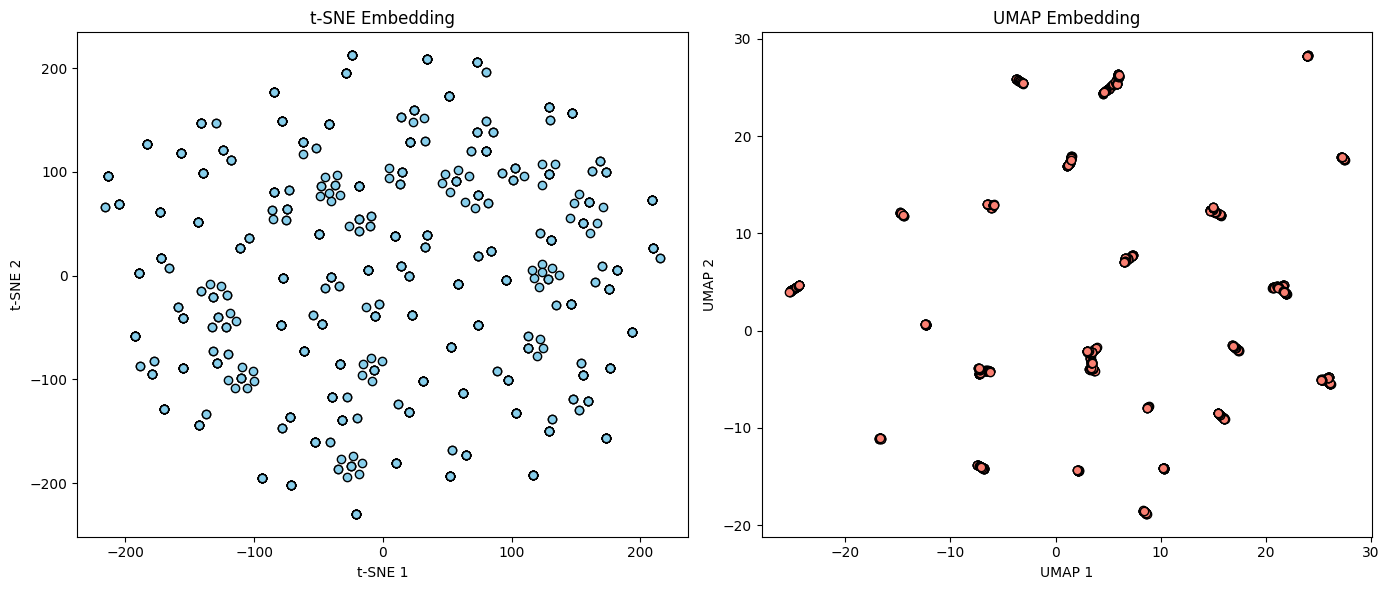

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='skyblue', edgecolor='k')
ax1.set_title("t-SNE Embedding")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")

ax2.scatter(X_umap[:, 0], X_umap[:, 1], c='salmon', edgecolor='k')
ax2.set_title("UMAP Embedding")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()


Coefficient of Variation (CV) for each metric:
                  Metric         CV
17     curvature_entropy   0.091443
4          speed_entropy   0.176295
8        avg_radius_mean   0.186618
5   acceleration_entropy   0.190732
6        braking_entropy   0.194588
11        avg_radius_var   0.295486
0                 length   0.314598
10           right_bends   0.326189
15            left_bends   0.333939
13     straight_sections   0.398527
16         positions_var   0.494610
9              gaps_mean   0.845669
1                 deltaX   1.249970
12       total_overtakes   2.452220
14              gaps_var   3.066890
3      deltaAngleDegrees  23.028859
7         positions_mean  31.511903
2                 deltaY  35.989959


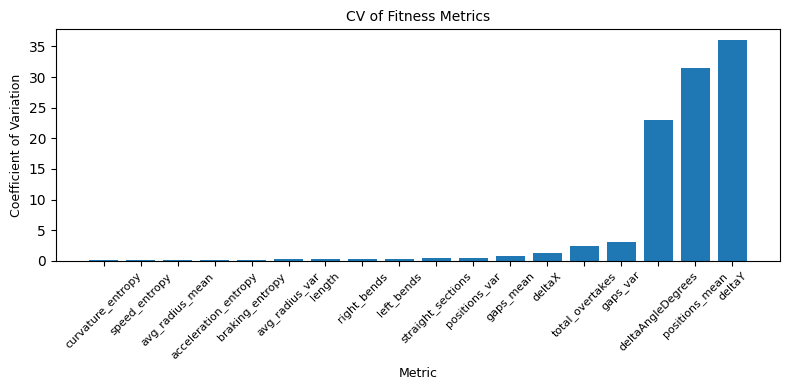

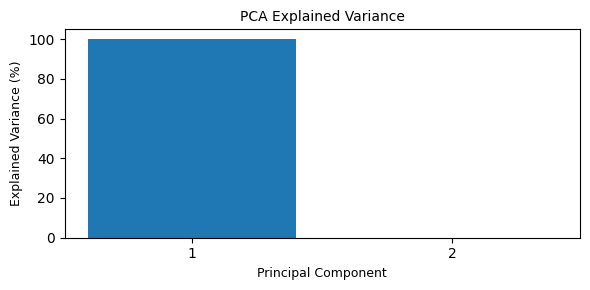

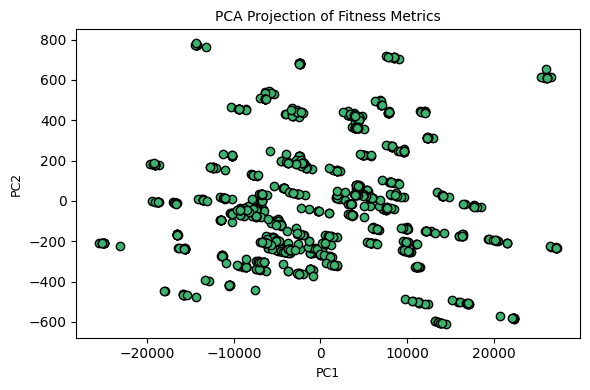

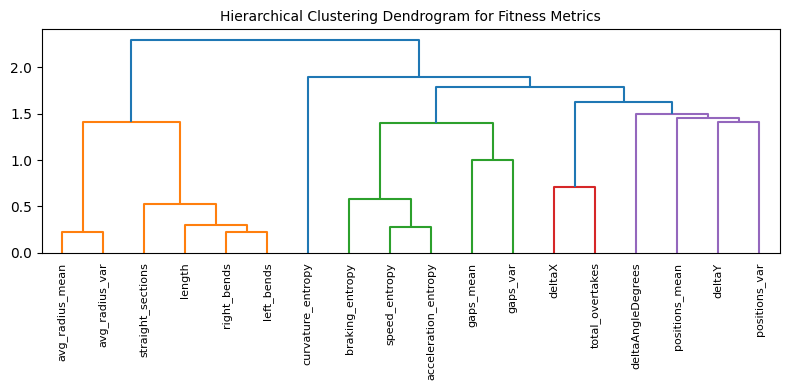

In [10]:
# %% [markdown]
# ## Additional Analysis: CV, PCA, and Hierarchical Clustering
#
# In this section, we expand the analysis with:
# 1. The coefficient of variation (CV) for each fitness metric.
# 2. A PCA on the fitness metrics to understand the variance structure.
# 3. A hierarchical clustering dendrogram of the fitness metrics based on their correlations.

# %%
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

# 1. Coefficient of Variation (CV) for each fitness metric
cv_values = {}
for metric in features:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    # Avoid division by zero; use absolute value of mean for safety
    cv_values[metric] = std_val / abs(mean_val) if mean_val != 0 else np.nan

cv_df = pd.DataFrame(list(cv_values.items()), columns=["Metric", "CV"])
cv_df.sort_values("CV", inplace=True)
print("Coefficient of Variation (CV) for each metric:")
print(cv_df)

plt.figure(figsize=(8, 4))
plt.bar(cv_df["Metric"], cv_df["CV"])
plt.xlabel("Metric", fontsize=9)
plt.ylabel("Coefficient of Variation", fontsize=9)
plt.title("CV of Fitness Metrics", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

# %%
# 2. Principal Component Analysis (PCA) on fitness metrics
fitness_data = df[features]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fitness_data)
explained_var = pca.explained_variance_ratio_

# Plot explained variance for the first two principal components
plt.figure(figsize=(6, 3))
plt.bar(range(1, 3), explained_var * 100)
plt.xlabel("Principal Component", fontsize=9)
plt.ylabel("Explained Variance (%)", fontsize=9)
plt.title("PCA Explained Variance", fontsize=10)
plt.xticks([1, 2])
plt.tight_layout()
plt.show()

# Scatter plot of the PCA projection
plt.figure(figsize=(6, 4))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='mediumseagreen', edgecolor='k')
plt.xlabel("PC1", fontsize=9)
plt.ylabel("PC2", fontsize=9)
plt.title("PCA Projection of Fitness Metrics", fontsize=10)
plt.tight_layout()
plt.show()

# %%
# 3. Hierarchical Clustering on the Correlation Matrix of Fitness Metrics
# Compute the correlation matrix using only the fitness metrics
corr_fitness = df[features].corr()

# Perform hierarchical clustering using average linkage
linked = sch.linkage(corr_fitness, method='average')

plt.figure(figsize=(8, 4))
dendro = sch.dendrogram(linked, labels=corr_fitness.columns, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram for Fitness Metrics", fontsize=10)
plt.tight_layout()
plt.show()


Correlate the 2D embedding coordinates with additional descriptors (e.g., noise metrics, overtaking scores).
- Use the embedding coordinates as descriptors for clustering or regression analyses.
- Experiment with hyperparameters (e.g., t-SNE perplexity, UMAP n_neighbors) to assess their impact.

Merged DataFrame shape: (993, 39)
Fitness metrics to visualize: ['length', 'deltaX', 'deltaY', 'deltaAngleDegrees', 'speed_entropy', 'acceleration_entropy', 'braking_entropy', 'positions', 'avg_radius', 'gaps', 'right_bends', 'avg_radius_var', 'total_overtakes', 'straight_sections', 'gaps_var', 'left_bends', 'positions_var', 'curvature_entropy']


KeyError: 'positions_mean'

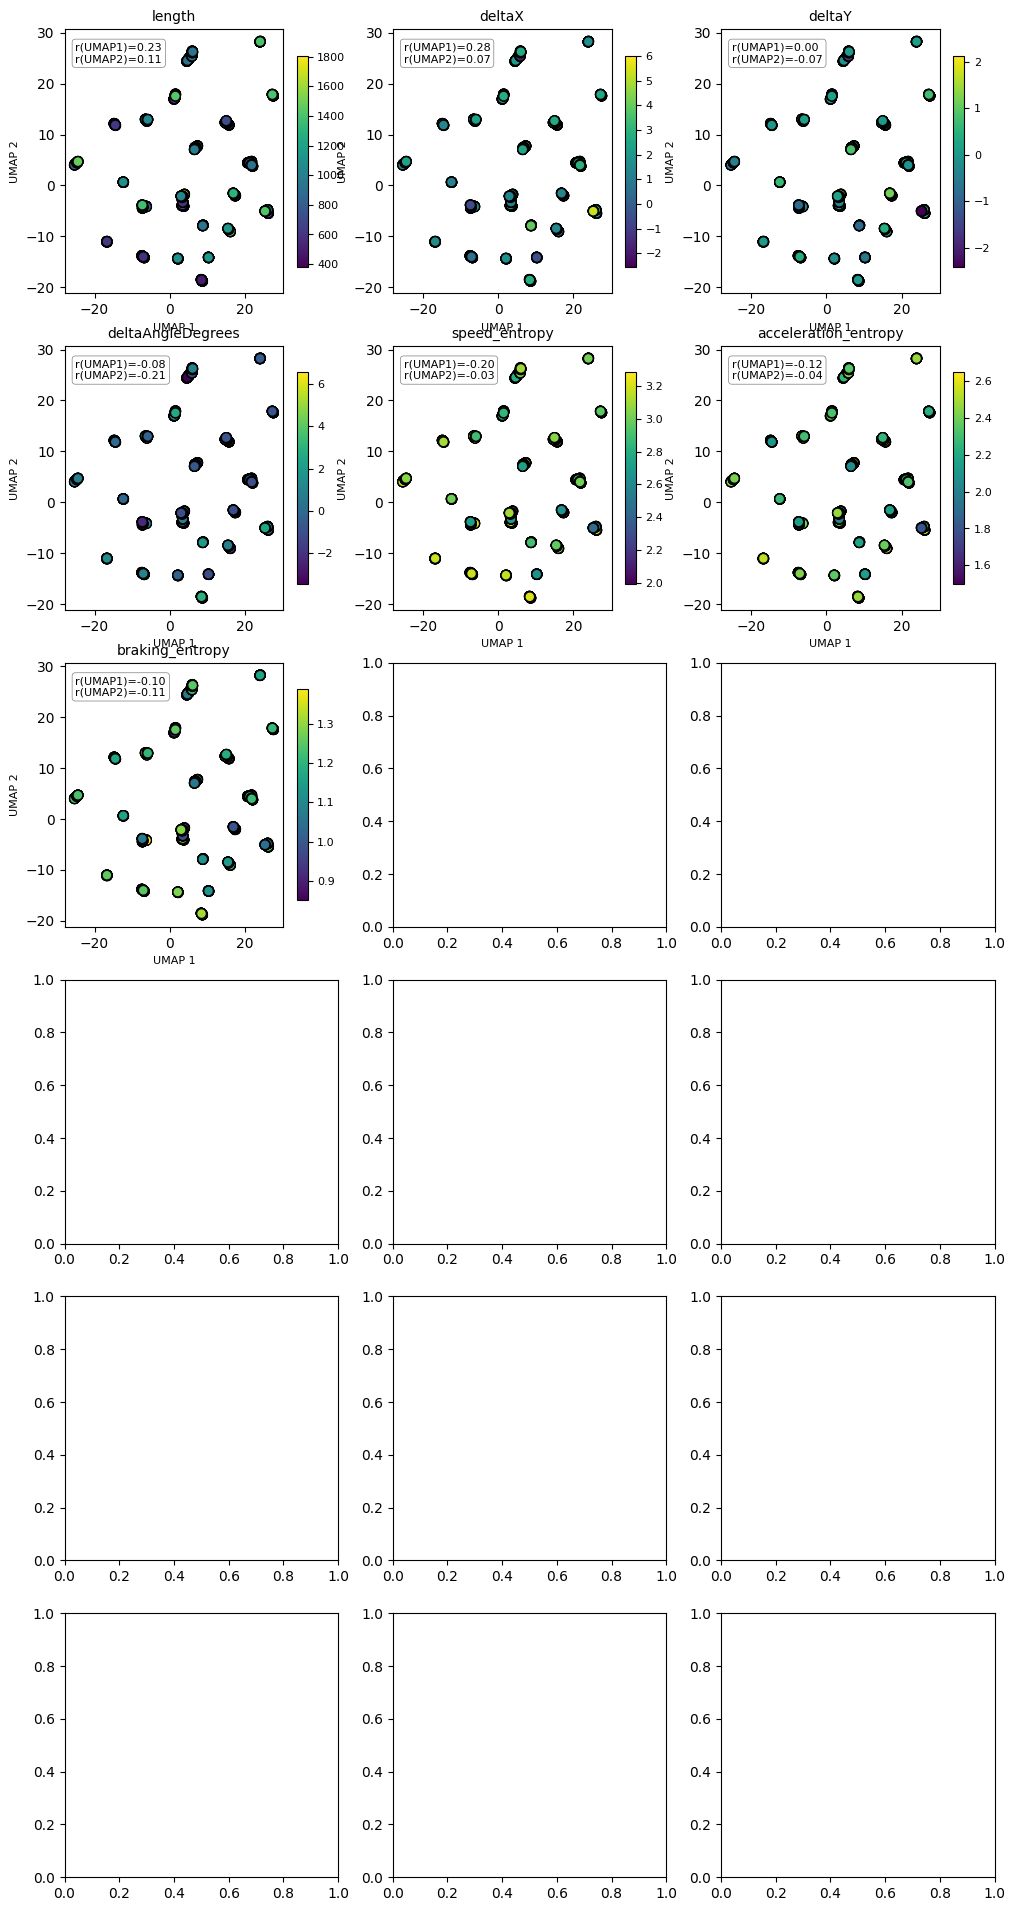

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

def visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats, fitness_metric_suffix='_mean', grid_cols=3):
    """
    Combines UMAP embedding with fitness descriptors and visualizes each fitness metric on a UMAP scatter plot.
    
    Parameters:
      - track_ids: List or array of track identifiers (from the spline vector loop).
      - X_umap: UMAP embedding array (2D) of shape (n_tracks, 2).
      - group_stats: DataFrame of aggregated fitness descriptors per track (with a 'seed' column).
      - fitness_metric_suffix: Suffix for fitness metric columns (default '_mean').
      - grid_cols: Number of columns in the subplot grid.
    """
    
    # Create a DataFrame from the UMAP embedding
    umap_df = pd.DataFrame({
        'id': track_ids,  # from the spline vector loop
        'umap_1': X_umap[:, 0],
        'umap_2': X_umap[:, 1]
    })
    
    # Attempt to convert 'id' to integer for merging with the fitness data (which uses 'seed')
    try:
        umap_df['id'] = umap_df['id'].astype(int)
    except Exception as e:
        print("Could not convert 'id' to int, merging based on string values:", e)
    
    # Prepare the fitness DataFrame (aggregated by track seed) by renaming 'seed' to 'id'
    fitness_df = group_stats.copy()
    fitness_df.rename(columns={'seed': 'id'}, inplace=True)
    
    # Merge the UMAP data with the fitness descriptors
    merged_df = pd.merge(umap_df, fitness_df, on='id', how='inner')
    print("Merged DataFrame shape:", merged_df.shape)
    
    # Automatically determine all metrics (fitness descriptors) based on columns ending with the given suffix
    metric_names = [col.replace(fitness_metric_suffix, '') for col in merged_df.columns if col.endswith(fitness_metric_suffix)]
    print("Fitness metrics to visualize:", metric_names)
    
    # Set up a grid for subplots
    n_metrics = len(metric_names)
    rows = math.ceil(n_metrics / grid_cols)
    fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols*4, rows*4), squeeze=False)
    
    # Loop through each metric and create the UMAP scatter plot
    for i, metric in enumerate(metric_names):
        ax = axes[i // grid_cols, i % grid_cols]
        color_col = f"{metric}{fitness_metric_suffix}"  # use the mean value of the fitness metric
        sc = ax.scatter(merged_df['umap_1'], merged_df['umap_2'],
                        c=merged_df[color_col], cmap='viridis', edgecolor='k', s=50)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("UMAP 1", fontsize=8)
        ax.set_ylabel("UMAP 2", fontsize=8)
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
        
        # Compute Pearson correlations between the fitness metric and the UMAP axes
        corr_umap1 = np.corrcoef(merged_df['umap_1'], merged_df[color_col])[0, 1]
        corr_umap2 = np.corrcoef(merged_df['umap_2'], merged_df[color_col])[0, 1]
        ax.annotate(f"r(UMAP1)={corr_umap1:.2f}\nr(UMAP2)={corr_umap2:.2f}", 
                    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
    
    # Remove any empty subplots if the grid is larger than needed
    for j in range(i + 1, rows * grid_cols):
        fig.delaxes(axes[j // grid_cols, j % grid_cols])
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume track_ids, X_umap, and group_stats are already defined from your earlier analysis
visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats)
